In [58]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Visualization Pipeline

In [59]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [60]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/scripts/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from vmpv.mat object
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Get duration map
# vmp = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/FiltVel/1px/vmpc.mat")
# vmp = vmp.get('vmp').get('data')
# dur_map = np.array(vmp.get('dur_raw')).flatten()



In [61]:
# Extract session time and position bins
# session_data = np.array(pv.get('sessionTimeC'))
# session_data = session_data[:,1:] # discard first row containing '0' timestamp
# timepoints, pos_bins = session_data[0,:], session_data[1,:]
place_intervals = get_place_intervals(pv)

# Convert spike timestamps to spiketrains, then to spike rates
# spiketrains = spike_trains_from_times(spike_times, timepoints)
# spikerates = spike_rates_from_trains(spiketrains, timepoints)
spikerates = spike_rates_per_observation(place_intervals, spike_times)

# Normalize spike counts within each cell for visualization only
normalized_spikerates = np.empty_like(spikerates)
for col in range(spikerates.shape[1]):
    normalized_spikerates[:,col] = normalize_dataset(spikerates[:,col])

In [62]:
# Set mindur and threshvel filter
min_dur = 0.05 # Minimum duration for an observation set to 50ms
thresh_vel = 1 # Set minimum velocity threshold to 1 unit/s

dur_intervals = place_intervals[:,1] - place_intervals[:,0]
max_dur = np.sqrt(2) * 0.625 / thresh_vel
valid_obs = np.where((dur_intervals > min_dur) & (dur_intervals <= max_dur))

# Apply mindur and threshvel filter
place_intervals = place_intervals[valid_obs]
spikerates = spikerates[valid_obs]
dur_intervals = dur_intervals[valid_obs]

In [63]:
def group_by_pos_bins(timeseries: np.array, pos_bins: np.array) -> list:
    num_bins = 1600
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_bins)]
    for idx, bin in enumerate(pos_bins):
        bin = int(bin)
        if bin == 0:
            continue
        bin -= 1
        grouped[bin] = np.vstack((grouped[bin], timeseries[idx,:]))
    return grouped

In [64]:
# Group spikes by position bins
responses_per_bin = group_by_pos_bins(spikerates, place_intervals[:,2])
normalized_responses_per_bin = group_by_pos_bins(normalized_spikerates, place_intervals[:,2])
dur_intervals = dur_intervals.reshape((-1, 1))
durations_per_bin = group_by_pos_bins(dur_intervals, place_intervals[:,2])

# Check number of responses per bin
num_responses_per_bin = np.array(list(map(lambda arr: arr.shape[0], responses_per_bin)))

# Check total number of responses across all bins, and max number of responses in any one bin
total_num_responses = np.sum(num_responses_per_bin)
max_num_responses = np.max(num_responses_per_bin)

In [65]:
def cosine_similarity(arr1: np.array, arr2: np.array) -> float:
    def magnitude(arr: np.array) -> float:
        return np.sqrt(np.dot(arr, arr))
    mag1, mag2 = magnitude(arr1), magnitude(arr2)
    if mag1 == 0 or mag2 == 0:
        return 0
    return np.dot(arr1, arr2) / (mag1 * mag2)

def bin_cosine_similarity_pairwise(bin: np.array) -> float:
    scores = list()
    for i in range(bin.shape[0] - 1):
        obs1 = bin[i,:]
        for j in range(i+1, bin.shape[0]):
            obs2 = bin[j,:]
            scores.append(cosine_similarity(obs1, obs2))
    if len(scores) == 0:
        return 1
    return np.mean(scores)

def bin_cosine_similarity_mean(bin: np.array, mean: np.array) -> float:
    scores = list()
    for i in range(bin.shape[0]):
        obs = bin[i,:]
        scores.append(cosine_similarity(obs, mean))
    if len(scores) == 0:
        return 1
    return np.mean(scores)

def crossbin_cosine_similarity(map: list) -> list:
    res = list()
    for bin in map:
        bin_res = np.zeros(1600)
        for num, comp in enumerate(map):
            bin_res[num] = cosine_similarity(bin.flatten(), comp.flatten())
        bin_res = bin_res.reshape((40, 40))
        res.append(bin_res)
    return res

def bin_mean(bin: np.array, durations: np.array) -> np.array:
    res = list()
    tot_dur = np.sum(durations)
    for cell in range(bin.shape[1]):
        obs = bin[:,cell]
        res.append(np.dot(obs, durations) / tot_dur)
    return np.array(res)

In [66]:
# Compute metrics for each bin
bin_means, bin_pair_sims, bin_mean_sims = list(), list(), list()
for num, bin in enumerate(responses_per_bin):
    durs = durations_per_bin[num]
    if bin.shape[0] > 0:
        mean = bin_mean(bin, durs)
        pair_sim = bin_cosine_similarity_pairwise(bin)
        mean_sim = bin_cosine_similarity_mean(bin, mean.flatten())
    else:
        mean = np.zeros(bin.shape[1])
        pair_sim, mean_sim = 0, 0
    bin_means.append(mean)
    bin_pair_sims.append(pair_sim)
    bin_mean_sims.append(mean_sim)

# Compute inter-bin metrics across all bins
crossbin_sims = crossbin_cosine_similarity(bin_means)

In [81]:
def plot_bin_response(num: int, bin_responses: np.array, bin_stats: tuple, savepath: str):
    plt.figure()
    ax1 = plt.subplot2grid((5, 10), (0, 0), colspan=7, rowspan=4)
    ax2 = plt.subplot2grid((5, 10), (0, 7), colspan=3, rowspan=2)
    ax3 = plt.subplot2grid((5, 10), (2, 7), colspan=3, rowspan=2)
    
    ax1.set_title(f'Place bin #{num} responses - {day_dir}')
    pcm = ax1.pcolormesh(bin_responses, cmap='viridis', vmin=0)
    ax1.grid(linewidth=0.25)
    ax1.set_xticks(np.arange(bin_responses.shape[1]), cell_labels, rotation=45)
    if bin_responses.shape[0] <= 10:
        ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1))
    elif bin_responses.shape[0] <= 20:
        ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 2))
    elif bin_responses.shape[0] <= 50:
        ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 5))
    else:
        ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 10))
    ax1.set_ylabel('Observations')
    plt.colorbar(pcm, ax=ax1, label='Firing Rate (95-percentile scaled)')

    xpos, ypos = [(num % 40) + 1], [int(num // 40) + 1]
    ax2.plot(xpos, ypos, marker='x', markeredgecolor='r')
    ax2.set_xlim([0, 40])
    ax2.set_ylim([0, 40])
    ax2.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
    ax2.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
    ax2.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
    ax2.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
    ax2.set_xticks([])
    ax2.set_yticks([])

    pair_sim, mean_sim, crossbin_sim = bin_stats
    pcm2 = ax3.pcolormesh(crossbin_sim, cmap='viridis', vmin=0, vmax=1)
    ax3.set_xticks([])
    ax3.set_yticks([])
    axins = inset_axes(ax3, height='100%', width='5%', loc='center right', borderpad=-1)
    plt.colorbar(pcm2, cax=axins, label='Cross-bin similarity', orientation='vertical')
    txt1 = f'Similarity within bin\n(pairwise): {pair_sim:.3f}'
    txt2 = f'Similarity within bin\n(vs mean): {mean_sim:.3f}'
    ax3.text(0, -0.3, txt1, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')
    ax3.text(0, -0.6, txt2, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')

    plt.savefig(f'{savepath}/bin{num}.png', bbox_inches='tight')
    plt.close()

In [82]:
# Plot responses for all bins with >1 response
savepath = '/Users/jcheng/Documents/neural_decoding/20181102/pos_bin_responses'
active_bins = 0
for num, bin in enumerate(normalized_responses_per_bin):
    if bin.shape[0] > 0:
        bin_stats = (bin_pair_sims[num], bin_mean_sims[num], crossbin_sims[num])
        plot_bin_response(num+1, bin, bin_stats, savepath)
        active_bins += 1

Individual Plots

([], [])

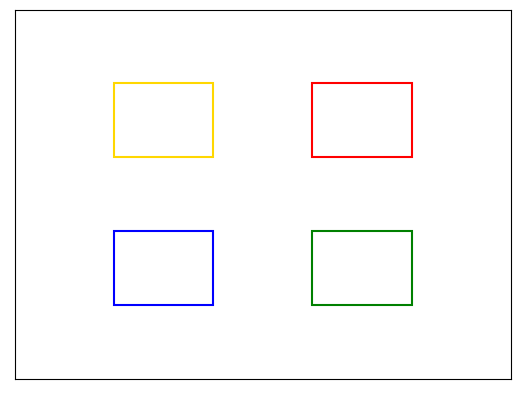

In [69]:
# Plot layout of maze
plt.figure('Maze Layout')
plt.xlim([0, 40])
plt.ylim([0, 40])
plt.gca().add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1.5))
plt.xticks([])
plt.yticks([])

In [87]:
# (x, y) coord to bin number translator (1-indexed)
pos_coords_to_bins((0, -10)) - 1

139

Text(0, -0.55, 'Similarity within bin\n(vs mean): 0.895')

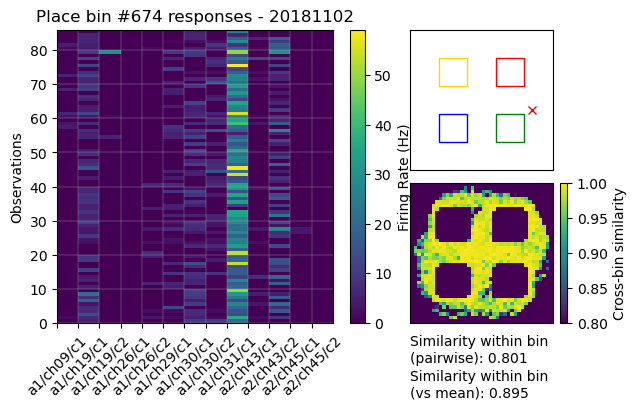

In [80]:
# Try plotting responses from one position bin
bin = 673  # 0-indexed, taking responses from bin+1
bin_responses = responses_per_bin[bin]
pair_sim = bin_pair_sims[bin]
mean_sim = bin_mean_sims[bin]
crossbin_sim = crossbin_sims[bin]

plt.figure(f'Bin #{bin+1}')
ax1 = plt.subplot2grid((5, 10), (0, 0), colspan=7, rowspan=4)
ax2 = plt.subplot2grid((5, 10), (0, 7), colspan=3, rowspan=2)
ax3 = plt.subplot2grid((5, 10), (2, 7), colspan=3, rowspan=2)

pcm = ax1.pcolormesh(bin_responses, cmap='viridis', vmin=0)
ax1.grid(which='both', linewidth=0.25)
ax1.set_xticks(np.arange(bin_responses.shape[1]), cell_labels, rotation=45)
if bin_responses.shape[0] <= 10:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1))
elif bin_responses.shape[0] <= 20:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 2))
elif bin_responses.shape[0] <= 50:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 5))
else:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 10))
# plt.axes().yaxis.set_minor_locator(MultipleLocator(1))
# plt.minorticks_on()
# plt.tick_params(which='minor',bottom=False,right=False)
plt.colorbar(pcm, ax=ax1, label='Firing Rate (Hz)', location='right')
# plt.xlabel('Cells')
ax1.set_ylabel('Observations')
ax1.set_title(f'Place bin #{bin+1} responses - {day_dir}')
xpos, ypos = [(bin % 40) + 1], [int(bin // 40) + 1]
ax2.plot(xpos, ypos, marker='x', markeredgecolor='r')
ax2.set_xlim([0, 40])
ax2.set_ylim([0, 40])
ax2.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
ax2.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
ax2.set_xticks([])
ax2.set_yticks([])

pcm2 = ax3.pcolormesh(crossbin_sim, cmap='viridis', vmin=0.8, vmax=1)
ax3.set_xticks([])
ax3.set_yticks([])
axins = inset_axes(ax3, height='100%', width='5%', loc='center right', borderpad=-1)
plt.colorbar(pcm2, cax=axins, label='Cross-bin similarity', orientation='vertical')
txt1 = f'Similarity within bin\n(pairwise): {pair_sim:.3f}'
txt2 = f'Similarity within bin\n(vs mean): {mean_sim:.3f}'
ax3.text(0, -0.3, txt1, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')
ax3.text(0, -0.55, txt2, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')

Text(0, -0.55, 'Similarity within bin\n(vs mean): 0.895')

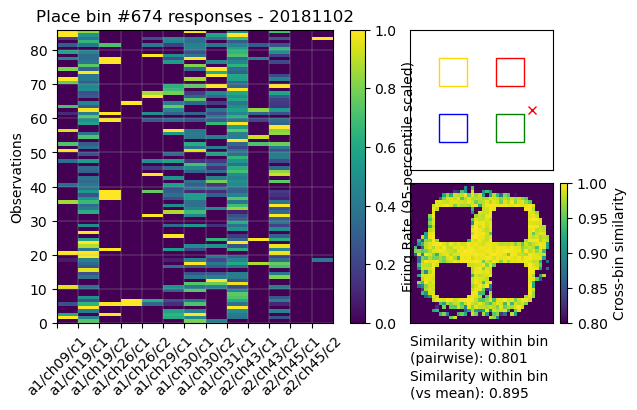

In [83]:
# Try plotting responses from one position bin (normalized)
bin = 673 # Taking responses from bin 1350
bin_responses = normalized_responses_per_bin[bin]
pair_sim = bin_pair_sims[bin]
mean_sim = bin_mean_sims[bin]
crossbin_sim = crossbin_sims[bin]

plt.figure(f'Bin #{bin+1}')
ax1 = plt.subplot2grid((5, 10), (0, 0), colspan=7, rowspan=4)
ax2 = plt.subplot2grid((5, 10), (0, 7), colspan=3, rowspan=2)
ax3 = plt.subplot2grid((5, 10), (2, 7), colspan=3, rowspan=2)

pcm = ax1.pcolormesh(bin_responses, cmap='viridis', vmin=0)
ax1.grid(which='both', linewidth=0.25)
ax1.set_xticks(np.arange(bin_responses.shape[1]), cell_labels, rotation=45)
if bin_responses.shape[0] <= 10:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1))
elif bin_responses.shape[0] <= 20:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 2))
elif bin_responses.shape[0] <= 50:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 5))
else:
    ax1.set_yticks(np.arange(0, bin_responses.shape[0]+1, 10))
# plt.axes().yaxis.set_minor_locator(MultipleLocator(1))
# plt.minorticks_on()
# plt.tick_params(which='minor',bottom=False,right=False)
plt.colorbar(pcm, ax=ax1, label='Firing Rate (95-percentile scaled)', location='right')
# plt.xlabel('Cells')
ax1.set_ylabel('Observations')
ax1.set_title(f'Place bin #{bin+1} responses - {day_dir}')
xpos, ypos = [(bin % 40) + 1], [int(bin // 40) + 1]
ax2.plot(xpos, ypos, marker='x', markeredgecolor='r')
ax2.set_xlim([0, 40])
ax2.set_ylim([0, 40])
ax2.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
ax2.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
ax2.set_xticks([])
ax2.set_yticks([])

pcm2 = ax3.pcolormesh(crossbin_sim, cmap='viridis', vmin=0.8, vmax=1)
ax3.set_xticks([])
ax3.set_yticks([])
axins = inset_axes(ax3, height='100%', width='5%', loc='center right', borderpad=-1)
plt.colorbar(pcm2, cax=axins, label='Cross-bin similarity', orientation='vertical')
txt1 = f'Similarity within bin\n(pairwise): {pair_sim:.3f}'
txt2 = f'Similarity within bin\n(vs mean): {mean_sim:.3f}'
ax3.text(0, -0.3, txt1, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')
ax3.text(0, -0.55, txt2, transform=ax3.transAxes, verticalalignment='bottom', horizontalalignment='left')

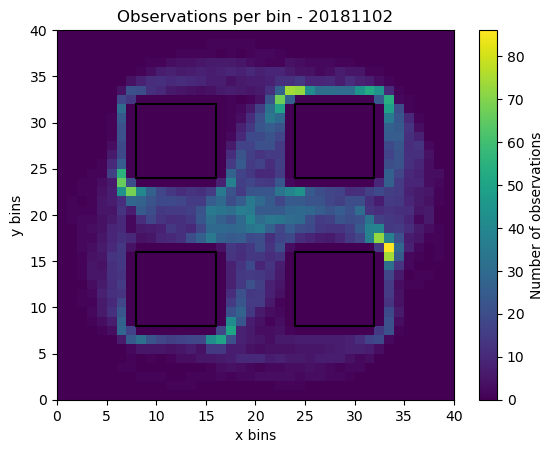

In [71]:
# Plot heatmap of number of responses across position bins
num_responses_per_bin = num_responses_per_bin.reshape((40, 40))
plt.figure('Position Heatmap')
plt.pcolormesh(num_responses_per_bin)
plt.colorbar(label='Number of observations')
plt.xlabel('x bins')
plt.ylabel('y bins')
plt.title(f'Observations per bin - {day_dir}')
plt.gca().add_patch(Rectangle((8, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((8, 24), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 24), 8, 8, fill=False, linewidth=1.5))
# plt.savefig(f'{savepath}/response_map.png')

In [72]:
# Bin with most observations
np.argmax(num_responses_per_bin)

673

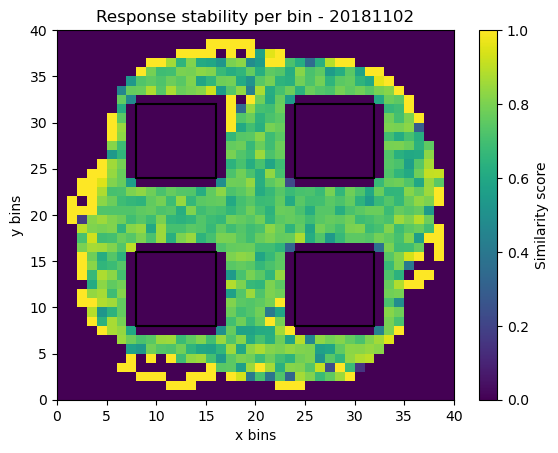

In [73]:
# Plot within-bin similarity scores across position bins
bin_sims_map = np.array(bin_pair_sims).reshape((40, 40))
plt.figure('Similarity Heatmap')
plt.pcolormesh(bin_sims_map)
plt.colorbar(label='Similarity score')
plt.xlabel('x bins')
plt.ylabel('y bins')
plt.title(f'Response stability per bin - {day_dir}')
plt.gca().add_patch(Rectangle((8, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((8, 24), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 24), 8, 8, fill=False, linewidth=1.5))
# plt.savefig(f'{savepath}/stability_map.png')

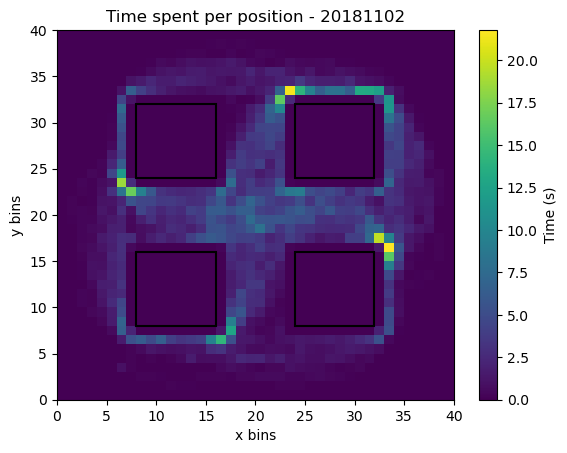

In [74]:
# Plot heatmap of duration spent in each position bin
dur_map = np.array([np.sum(bin) for bin in durations_per_bin]).reshape((40, 40))
plt.figure('Position Heatmap 2')
plt.pcolormesh(dur_map)
plt.colorbar(label='Time (s)')
plt.xlabel('x bins')
plt.ylabel('y bins')
plt.title(f'Time spent per position - {day_dir}')
plt.gca().add_patch(Rectangle((8, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((8, 24), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 24), 8, 8, fill=False, linewidth=1.5))
# plt.savefig(f'{savepath}/duration_map.png')

In [75]:
# Average similarity score within-bin across all bins
response_counts = num_responses_per_bin.flatten()
similarity_scores = bin_sims_map.flatten()
avg_sim_score = np.dot(response_counts, similarity_scores) / np.sum(response_counts)
print(f"Average bin similarity: {avg_sim_score}")


Average bin similarity: 0.7314155149119822


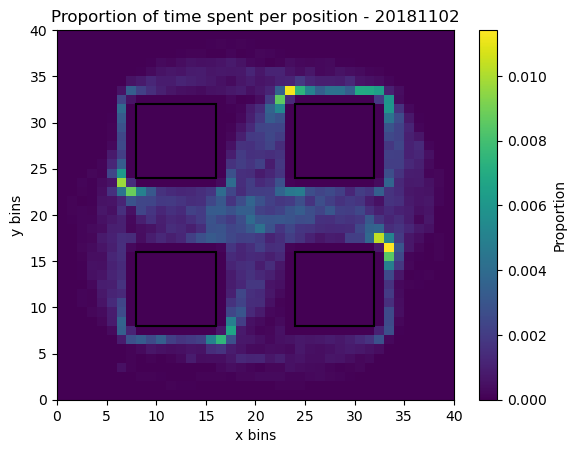

In [77]:
# Convert duration map to proportion of total time spent in each position bin
dur_prop_map = np.divide(dur_map, np.sum(dur_map))

# Plot heatmap of proportion of total time spent in each position bin
dur_prop_map = dur_prop_map.reshape((40, 40))
plt.figure('Position Heatmap 2')
plt.pcolormesh(dur_prop_map)
plt.colorbar(label='Proportion')
plt.xlabel('x bins')
plt.ylabel('y bins')
plt.title(f'Proportion of time spent per position - {day_dir}')
plt.gca().add_patch(Rectangle((8, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((8, 24), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 8), 8, 8, fill=False, linewidth=1.5))
plt.gca().add_patch(Rectangle((24, 24), 8, 8, fill=False, linewidth=1.5))